# Potabilities - Water Quality Evaluation

Potabilites is a start-up manufacturing a groundbreaking new device that will be able to quickly and cheaply test the potability of water anywhere in the world. 
As the engineers at Potabilities work on the physical testing device, our team was hired to develop the model this device will use to determine whether the water sample is potable according to the World Health Organization and US Environmental Protection Agency standards.

In [6]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.express    as px
import scipy.stats       as stats
import pydotplus

from six                  import StringIO
from IPython.display      import Image
from data.ds_models       import ds_models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline                import Pipeline
from sklearn.impute                  import SimpleImputer, KNNImputer
from sklearn.preprocessing           import StandardScaler, OneHotEncoder, normalize
from sklearn.model_selection         import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics                 import mean_squared_error, mean_squared_log_error, accuracy_score
from sklearn.metrics                 import plot_confusion_matrix, classification_report

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.tree         import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble     import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble     import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm          import SVC

import warnings
warnings.filterwarnings('ignore')

# Data Exploration and Cleaning

Our data was obtained from the Water Quality Dataset from Kaggel, available at https://www.kaggle.com/adityakadiwal/water-potability. It contained 3,270 samples from water bodies all over the world. It contains nine features that the WHO and USEPA consider important in evaluating the potability of water. 

In [7]:
df = pd.read_csv('data/water_potability.csv')

In [8]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Raw Potability Histogram

First we explored the distribution of our target variable and discovered that we had a class imbalance of 1,998 non-potable samples and 1,278 that were potable. 

(array([1998.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1278.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

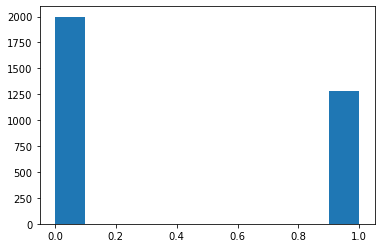

In [9]:
plt.hist(df['Potability'])

### Scatter Plot of Features

Considering the class imbalance we decided to check the separability of our target data. By generating a scaled scatterplot we were able to see a clear separability which showed us that we did not need to worry about balancing our data with Smote or other techniques. 

In [10]:
scaler       = StandardScaler()
scaler.fit(df)
df_scaled    = scaler.transform(df)
df_a         = pd.DataFrame(df_scaled)
df_a.columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']
px.scatter(df_a, title ='Relationship Between Potable and Non-Potable Water')

### Exploring NaN values

Next we checked for any Null values in our data and discovered that 1,434 entries contained Null values. Since this is a fairly large chunk of our data we decided that we should try to fill in these gaps if possible. 

In [11]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [13]:
df_scrub = df.dropna()
df_scrub.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### Correlation Check

We checked our features for multicollinearity and found that all of our features seemed very independent of each other.

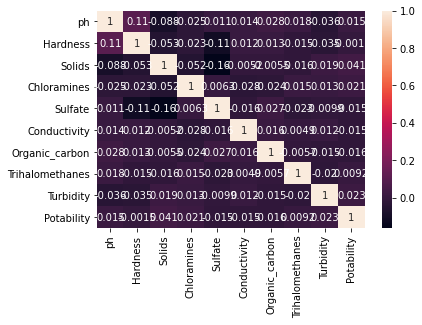

In [14]:
sns.heatmap(df_scrub.corr(), annot=True);

In [15]:
df_scrub.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.108948,-0.087615,-0.024768,0.010524,0.014128,0.028375,0.018278,-0.035849,0.014530
Hardness,0.108948,1.000000,-0.053269,-0.022685,-0.108521,0.011731,0.013224,-0.015400,-0.034831,-0.001505
Solids,-0.087615,-0.053269,1.000000,-0.051789,-0.162769,-0.005198,-0.005484,-0.015668,0.019409,0.040674
Chloramines,-0.024768,-0.022685,-0.051789,1.000000,0.006254,-0.028277,-0.023808,0.014990,0.013137,0.020784
Sulfate,0.010524,-0.108521,-0.162769,0.006254,1.000000,-0.016192,0.026776,-0.023347,-0.009934,-0.015303
Conductivity,0.014128,0.011731,-0.005198,-0.028277,-0.016192,1.000000,0.015647,0.004888,0.012495,-0.015496
Organic_carbon,0.028375,0.013224,-0.005484,-0.023808,0.026776,0.015647,1.000000,-0.005667,-0.015428,-0.015567
Trihalomethanes,0.018278,-0.015400,-0.015668,0.014990,-0.023347,0.004888,-0.005667,1.000000,-0.020497,0.009244
Turbidity,-0.035849,-0.034831,0.019409,0.013137,-0.009934,0.012495,-0.015428,-0.020497,1.000000,0.022682
Potability,0.014530,-0.001505,0.040674,0.020784,-0.015303,-0.015496,-0.015567,0.009244,0.022682,1.000000


Considering all of our data exploration we decided that it would be best to test our models on 4 different data sets:

# Data Instantiation

### Raw Data

Raw Data with filled in NaN values using a Nearest Neighbors Classifier model which would fill in any NaNs based on their 5 closest neighbors.

In [19]:
X = df.drop(columns=['Potability'], axis=1)
y = df['Potability']

### Dropping NaNs Data

Data with all of our Null values dropped.

In [20]:
df_dn = df.dropna()
X_dn  = df_dn.drop(columns=['Potability'], axis=1)
y_dn  = df_dn['Potability']

### Dropping Outliers Data

Raw Data with filled in Null values using a Nearest Neighbors Classifier model which would fill in any NaNs based on their 5 closest neighbors while dropping outlier data.

In [21]:
Q1     = df.quantile(0.25)
Q3     = df.quantile(0.75)
IQR    = df.apply(stats.iqr)
df_out = df[~((X < (Q1-1.5*IQR)) | (X > Q3+1.5*IQR)).any(axis=1)]

X_do   = df_out.drop(columns=['Potability'], axis=1)
y_do   = df_out['Potability']

### Dropping Outliers and NaNs Data

Data with all of our Null and outlier values dropped.

In [36]:
Q1      = df_dn.quantile(0.25)
Q3      = df_dn.quantile(0.75)
IQR     = df_dn.apply(stats.iqr)
df_out  = df_dn[~((X < (Q1-1.5*IQR)) | (X > Q3+1.5*IQR)).any(axis=1)]

X_dn_do = df_dn.drop(columns=['Potability'], axis=1)
y_dn_do = df_dn['Potability']

# Model Instantiations

We set up the instantiation of all of our classification models for easy access in our testing phase.

## Gaussian Naive Bayes

In [18]:
#model = GaussianNB()

#model = BaggingClassifier(GaussianNB())

#model = AdaBoostClassifier(GaussianNB())

## KNeighbors Classifier

In [19]:
#model      = KNeighborsClassifier()

#knc_grid   = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}
#model      = GridSearchCV(KNeighborsClassifier(), knc_grid, scoring='accuracy', verbose=1)

#model      = AdaBoostClassifier(KNeighborsClassifier())

## Logistic Regression

In [20]:
#model       = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs', multi_class='auto')

#logreg_grid = {'C': [1, 2, 3], 'solver': [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]}
#model       = GridSearchCV(LogisticRegression(), logreg_grid, scoring='accuracy', verbose=1)

## Decision Tree Classifier

In [21]:
#model    = DecisionTreeClassifier()

#dtc_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5]}
#model    = GridSearchCV(DecisionTreeClassifier(), dtc_grid, scoring='accuracy', verbose=1)

## Bagging Classifier

In [22]:
#model   = BaggingClassifier()

#bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
#model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

## Random Forest Classifier

In [23]:
#model    = RandomForestClassifier()

#rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
#            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
#model    = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

## Adaptive Boosting Classifier

In [24]:
#model = AdaBoostClassifier()

## Gradient Boosting Classifier

In [25]:
#model = GradientBoostingClassifier()

## Support Vector Classification

In [26]:
#model    = SVC()

#svc_grid = {'C': [1, 2, 3], 'kernel': [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]}
#model    = GridSearchCV(SVC(), svc_grid, scoring='accuracy', verbose=1)

# Model Testing

After extensive testing using 4 versions of our data we narrowed our ideal models to the top 3 performers:
- Gradient Boosting Classifier
- Random Forest Classifier
- Bagging Classifier

### Bagging Classifier - NaNs Filled w/KNN - Gridsearch - 64% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   25.6s finished


Bagging Classifier - NaNs w/KNN- Gridsearch Train Data Confusion Matrix:



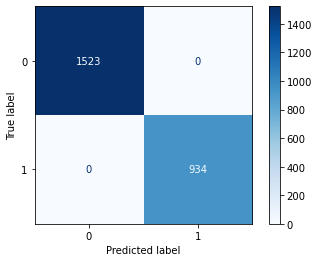

Bagging Classifier - NaNs w/KNN- Gridsearch Test Data Confusion Matrix:



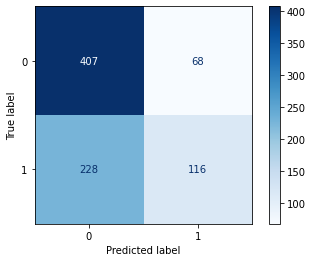

Bagging Classifier - NaNs w/KNN- Gridsearch Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Bagging Classifier - NaNs w/KNN- Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       475
           1       0.63      0.34      0.44       344

    accuracy                           0.64       819
   macro avg       0.64      0.60      0.59       819
weighted avg       0.64      0.64      0.61       819



In [23]:
bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

bc_gs   = ds_models(model, X, y, model_name='Bagging Classifier - NaNs w/KNN- Gridsearch',
                    output='class', imputer=True)


In [24]:
bc_gs

GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Bagging Classifier - Dropped NaNs - 66% Test Accuracy

Bagging Classifier - Dropped NaNs Train Data Confusion Matrix:



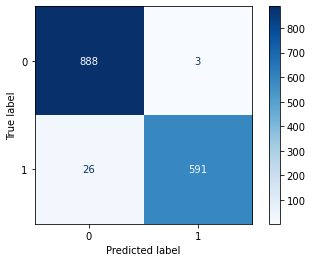

Bagging Classifier - Dropped NaNs Test Data Confusion Matrix:



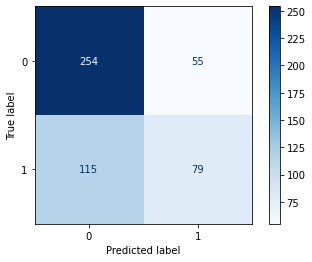

Bagging Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       891
           1       0.99      0.96      0.98       617

    accuracy                           0.98      1508
   macro avg       0.98      0.98      0.98      1508
weighted avg       0.98      0.98      0.98      1508

Bagging Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       309
           1       0.59      0.41      0.48       194

    accuracy                           0.66       503
   macro avg       0.64      0.61      0.62       503
weighted avg       0.65      0.66      0.65       503



In [25]:
model = BaggingClassifier()

bc_dn = ds_models(model, X_dn, y_dn, model_name='Bagging Classifier - Dropped NaNs',
                  output='class')


In [26]:
bc_dn

BaggingClassifier()

### Bagging Classifier - Dropped NaNs - Gridsearch - 70% Test Accuracy

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   21.3s finished


Bagging Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



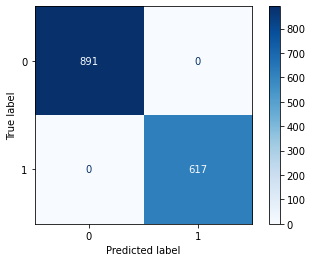

Bagging Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



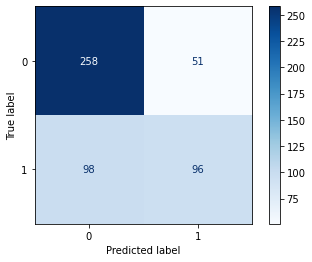

Bagging Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Bagging Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.72      0.83      0.78       309
           1       0.65      0.49      0.56       194

    accuracy                           0.70       503
   macro avg       0.69      0.66      0.67       503
weighted avg       0.70      0.70      0.69       503



In [31]:
bc_grid  = {'n_estimators': [10, 20, 30, 40, 50, 60], 'oob_score':['True', 'False']}
model    = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

bc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Bagging Classifier - Dropped NaNs - Gridsearch',
                     output='class')


In [28]:
bc_dn_gs

GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Bagging Classifier - Dropped Outliers - 66% Test Accuracy

Bagging Classifier - No Outliers, NaNs Filled Train Data Confusion Matrix:



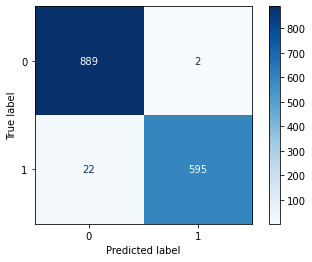

Bagging Classifier - No Outliers, NaNs Filled Test Data Confusion Matrix:



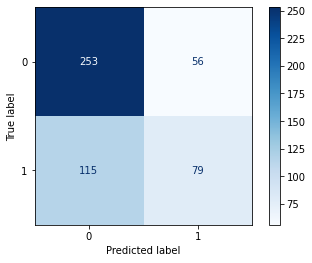

Bagging Classifier - No Outliers, NaNs Filled Train Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       891
           1       1.00      0.96      0.98       617

    accuracy                           0.98      1508
   macro avg       0.99      0.98      0.98      1508
weighted avg       0.98      0.98      0.98      1508

Bagging Classifier - No Outliers, NaNs Filled Test Report:

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       309
           1       0.59      0.41      0.48       194

    accuracy                           0.66       503
   macro avg       0.64      0.61      0.61       503
weighted avg       0.65      0.66      0.64       503



In [32]:
model = BaggingClassifier()

bc_do = ds_models(model, X_do, y_do, model_name='Bagging Classifier - No Outliers, NaNs Filled',
                  imputer=True, output='class')


In [34]:
bc_do

BaggingClassifier()

### Bagging Classifier - Dropped NaNs, Dropped Outliers - 68% Test Accuracy

Bagging Classifier - No Outliers, No NaNs Train Data Confusion Matrix:



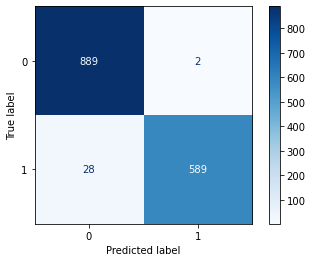

Bagging Classifier - No Outliers, No NaNs Test Data Confusion Matrix:



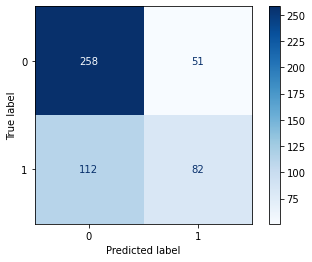

Bagging Classifier - No Outliers, No NaNs Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       891
           1       1.00      0.95      0.98       617

    accuracy                           0.98      1508
   macro avg       0.98      0.98      0.98      1508
weighted avg       0.98      0.98      0.98      1508

Bagging Classifier - No Outliers, No NaNs Test Report:

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       309
           1       0.62      0.42      0.50       194

    accuracy                           0.68       503
   macro avg       0.66      0.63      0.63       503
weighted avg       0.67      0.68      0.66       503



In [37]:
model = BaggingClassifier()

bc_dn_do = ds_models(model, X_dn_do, y_dn_do, model_name='Bagging Classifier - No Outliers, No NaNs',
                  output='class')


In [38]:
bc_dn_do

BaggingClassifier()

### Random Forest Classifier - NaNs Filled w/KNN - 65% Test Accuracy

Random Forest Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



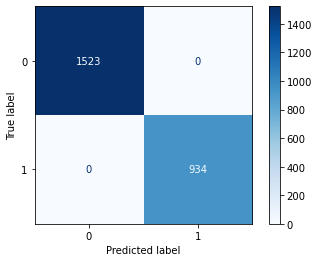

Random Forest Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



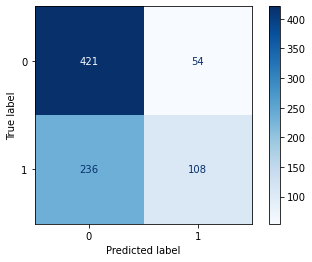

Random Forest Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Random Forest Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.64      0.89      0.74       475
           1       0.67      0.31      0.43       344

    accuracy                           0.65       819
   macro avg       0.65      0.60      0.59       819
weighted avg       0.65      0.65      0.61       819

Feature Importances:

[0.13176356 0.121561   0.11046479 0.1127662  0.13268979 0.10338808
 0.09653411 0.09629219 0.0945403 ]


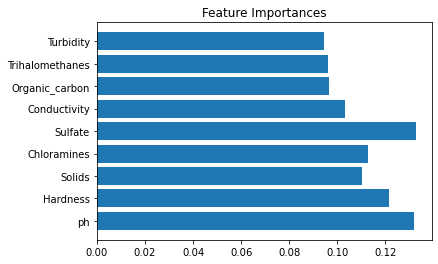

In [39]:
model = RandomForestClassifier()

rfc   = ds_models(model, X, y, model_name='Random Forest Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True, fi=True)


In [40]:
rfc

RandomForestClassifier()

### Random Forest Classifier - Dropped NaNs - 67% Test Accuracy

Random Forest Classifier - Dropped NaNs Train Data Confusion Matrix:



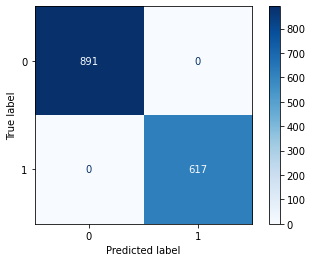

Random Forest Classifier - Dropped NaNs Test Data Confusion Matrix:



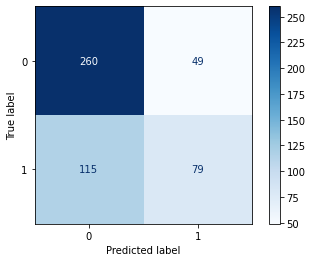

Random Forest Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Random Forest Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       309
           1       0.62      0.41      0.49       194

    accuracy                           0.67       503
   macro avg       0.66      0.62      0.63       503
weighted avg       0.66      0.67      0.66       503



In [41]:
model  = RandomForestClassifier()

rfc_dn = ds_models(model, X_dn, y_dn, model_name='Random Forest Classifier - Dropped NaNs',
                   output='class')


In [42]:
rfc_dn

RandomForestClassifier()

### Random Forest Classifier - Dropped NaNs - Gridsearch - 68% Test Accuracy

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.8min finished


Random Forest Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



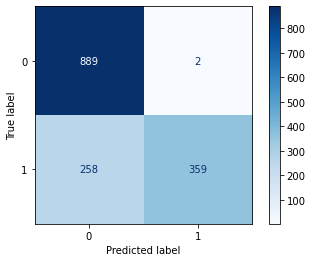

Random Forest Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



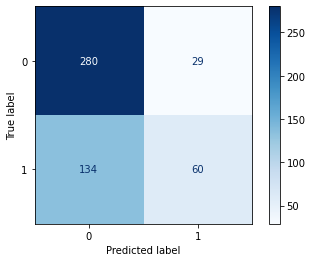

Random Forest Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       891
           1       0.99      0.58      0.73       617

    accuracy                           0.83      1508
   macro avg       0.88      0.79      0.80      1508
weighted avg       0.86      0.83      0.82      1508

Random Forest Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.68      0.91      0.77       309
           1       0.67      0.31      0.42       194

    accuracy                           0.68       503
   macro avg       0.68      0.61      0.60       503
weighted avg       0.68      0.68      0.64       503



In [43]:
rfc_grid  = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
model     = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

rfc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Random Forest Classifier - Dropped NaNs - Gridsearch', 
                      output='class')


In [44]:
rfc_dn_gs

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Random Forest Classifier - Dropped Outliers, NaNs Filled - 67% Test Accuracy

Random Forest Classifier - Dropped Outliers Train Data Confusion Matrix:



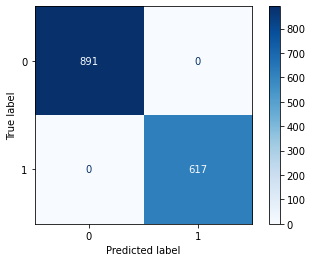

Random Forest Classifier - Dropped Outliers Test Data Confusion Matrix:



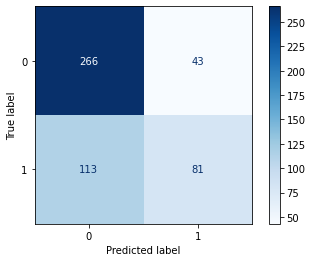

Random Forest Classifier - Dropped Outliers Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Random Forest Classifier - Dropped Outliers Test Report:

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       309
           1       0.65      0.42      0.51       194

    accuracy                           0.69       503
   macro avg       0.68      0.64      0.64       503
weighted avg       0.68      0.69      0.67       503

Feature Importances:

[0.14232146 0.11481969 0.10814444 0.11336661 0.14457475 0.09102305
 0.0939193  0.09798188 0.09384882]


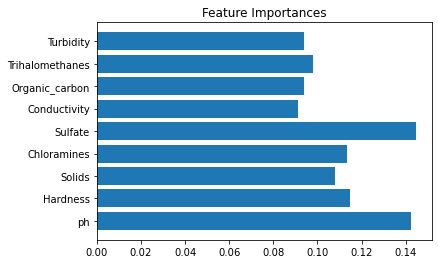

In [45]:
model  = RandomForestClassifier()

rfc_do = ds_models(model, X_do, y_do, model_name='Random Forest Classifier - Dropped Outliers',
                  output='class', imputer=True, fi=True)


In [46]:
rfc_do

RandomForestClassifier()

### Random Forest Classifier - Dropped Outliers, Dropped NaNs - 68 % Test Accuracy

Random Forest Classifier - Dropped Outliers & Dropped NaNs Train Data Confusion Matrix:



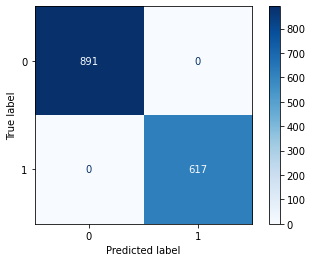

Random Forest Classifier - Dropped Outliers & Dropped NaNs Test Data Confusion Matrix:



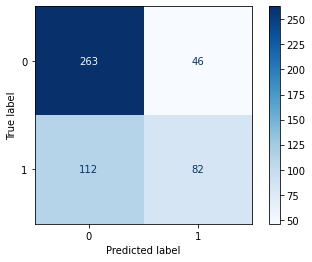

Random Forest Classifier - Dropped Outliers & Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Random Forest Classifier - Dropped Outliers & Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       309
           1       0.64      0.42      0.51       194

    accuracy                           0.69       503
   macro avg       0.67      0.64      0.64       503
weighted avg       0.68      0.69      0.67       503

Feature Importances:

[0.13343397 0.11143402 0.10728042 0.1181519  0.14527669 0.09630741
 0.09819977 0.09443764 0.0954782 ]


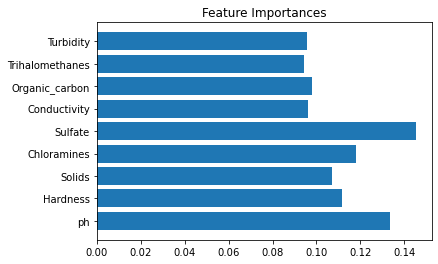

In [47]:
model     = RandomForestClassifier()

rfc_dn_do = ds_models(model, X_dn_do, y_dn_do, model_name='Random Forest Classifier - Dropped Outliers & Dropped NaNs',
                  output='class', fi=True)


In [48]:
rfc_dn_do

RandomForestClassifier()

### Gradient Boosting Classifier - Dropped Outliers & NaNs - 67% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished


Decision Tree Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



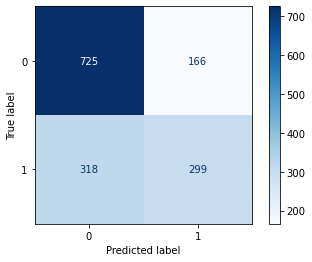

Decision Tree Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



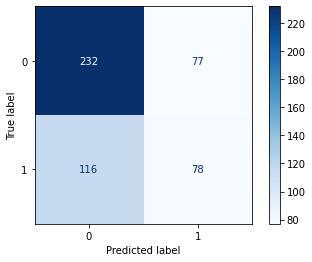

Decision Tree Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       891
           1       0.64      0.48      0.55       617

    accuracy                           0.68      1508
   macro avg       0.67      0.65      0.65      1508
weighted avg       0.67      0.68      0.67      1508

Decision Tree Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       309
           1       0.50      0.40      0.45       194

    accuracy                           0.62       503
   macro avg       0.58      0.58      0.58       503
weighted avg       0.60      0.62      0.61       503



In [45]:
model     = GradientBoostingClassifier()

gbc_dn_do = ds_models(model, X_dn_do, y_dn_do, model_name='Gradient Boosting Classifier - Dropped NaNs Dropped Outliers',
                   output='class', fi=True)


In [46]:
gbc_dn_do

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5]},
             scoring='accuracy', verbose=1)

### Gradient Boosting Classifier - Dropped Outliers, Filled NaNs - 66% Test Accuracy

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Train Data Confusion Matrix:



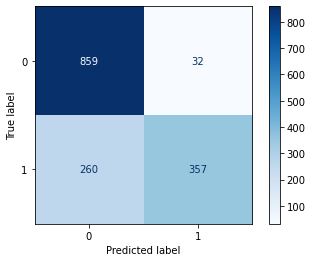

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Test Data Confusion Matrix:



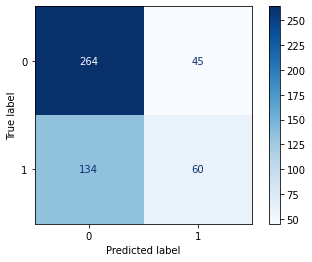

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Train Report:

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       891
           1       0.92      0.58      0.71       617

    accuracy                           0.81      1508
   macro avg       0.84      0.77      0.78      1508
weighted avg       0.83      0.81      0.80      1508

Gradient Boosting Classifier - Dropped Outliers, Filled NaNs Test Report:

              precision    recall  f1-score   support

           0       0.66      0.85      0.75       309
           1       0.57      0.31      0.40       194

    accuracy                           0.64       503
   macro avg       0.62      0.58      0.57       503
weighted avg       0.63      0.64      0.61       503

Feature Importances:

[0.2543558  0.10702602 0.07845558 0.11611035 0.2012923  0.04303654
 0.07306924 0.06648768 0.0601665 ]


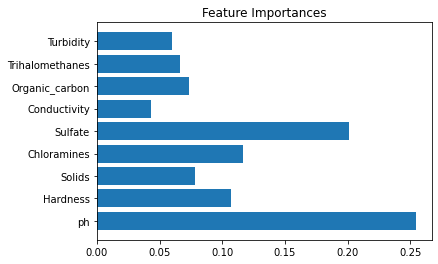

In [50]:
model  = GradientBoostingClassifier()

gbc_do = ds_models(model, X_do, y_do, model_name='Gradient Boosting Classifier - Dropped Outliers, Filled NaNs',
                   imputer=True, output='class', fi=True)


In [51]:
gbc_do

GradientBoostingClassifier()

## Summary and Next Steps

Our top model turned out to be a Gridsearch version of the Bagging Classifier which gave us a 70% accuracy on our test data. Our model precision for non-potable water is slightly higher than for potable, which we are encouraged by since we would absolutely prefer to lean on the side of caution with our life and death recommendations.

Continuing to improve our model will require further testing by manipulating our Gridsearch parameters. We would also like to try some other methods of filling our NaN values, for example with the standard average. The most surefire way of improving our model will be through the collection of new, complete data which means that the device Potabilites is building will actually become more accurate as it is used on new water samples. As more data becomes available we would like to see if splitting the data by region can have an effect on the performance of our model.